# Product Category Classification with DistilBERT
*Fine-tuning a transformer to classify e-commerce product descriptions*

## Import Libraries

Libraries required for data processing and modeling are imported.

This project runs in Google Colab to make use of the free GPU support.
Start by mounting Google Drive to access the project files. If this is your first time running the project, clone the repository. Otherwise, pull the latest changes to stay up to date.
Once that’s done, run the setup script to install any dependencies and make sure the environment is ready to go.

In [1]:
# Mount Drive on colab manually
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# If the repo doesn't exist in Google Drive, clone it
# !git clone https://github.com/herrerovir/Product-category-classifier

# If the repo does exist:
%cd /content/drive/MyDrive/Colab_Projects/Product-category-classifier
!git pull

/content/drive/MyDrive/Colab_Projects/Product-category-classifier
Updating 0af5209..b68030d
error: Your local changes to the following files would be overwritten by merge:
	notebooks/Product-category-classification.ipynb
Please commit your changes or stash them before you merge.
error: The following untracked working tree files would be overwritten by merge:
	figures/distilBERT-model-confusion-matrix.png
	figures/product-category-distribution.png
	results/metrics/distilBERT-classification-report.txt
	results/metrics/distilBERT-model-evaluation-metrics.txt
	results/predictions/predictions_output.txt
Please move or remove them before you merge.
Aborting


In [3]:
# Import colab_up file
import colab_setup
colab_setup.setup(subdir = "notebooks")
from colab_setup import *

Working directory set to: /content/drive/MyDrive/Colab_Projects/Product-category-classifier/notebooks


In [4]:
# Install dependencies
!pip install evaluate

# Utilities
import re
import torch
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Hugging Face Transformers
from transformers import (
    AutoModelForSequenceClassification,
    DistilBertTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    TextClassificationPipeline
)
import transformers

# Datasets
from datasets import Dataset, DatasetDict

# Evaluation
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


## Data Loading

The dataset is loaded from a CSV file into a pandas DataFrame.

In [5]:
data = pd.read_csv(RAW_DIR / "ecomm_data.csv")
data.head()

,Household,"Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss.so bring home this elegant print that is lushed with rich colors that makes it nothing but sheer elegance to be to your friends and family.it would be treasured forever by whoever your lucky recipient is. Liven up your place with these intriguing paintings that are high definition hd graphic digital prints for home, office or any room."
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


In [6]:
print(f"Original dataset shape: {data.shape}")

Original dataset shape: (50424, 2)


## Data Cleaning

Cleaning steps include renaming columns for consistency, removing null values, and dropping duplicate rows to ensure data quality before modeling.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50424 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

### Rename Columns

Column names are updated for clarity and consistency, making the data easier to work with throughout the project.

In [8]:
data.columns

Index(['Household', 'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and s

In [9]:
data = data.rename(columns = {data.columns[0]: "label", data.columns[1]: "product_description"})
data.head()

,label,product_description
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


### Null Values

Rows containing null values are removed to maintain data integrity. This helps ensure the dataset is complete and reduces potential issues during analysis and modeling.

In [10]:
data.isna().sum()

,0
label,0
product_description,1


In [11]:
data = data.dropna()

In [12]:
print(f"Missing values are dropped from the dataset. New dataset shape: {data.shape}")

Missing values are dropped from the dataset. New dataset shape: (50423, 2)


### Duplicated Values

Rows that have duplicate values across all columns are identified and removed. This helps prevent redundant data from affecting the analysis and model performance.

In [13]:
full_dupes = data[data.duplicated()]
print(f"Full duplicate rows: {full_dupes.shape[0]}")

Full duplicate rows: 22622


In [14]:
# Show a sample of duplicated rows
full_dupes.head(10)

,label,product_description
6,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
10,Household,Paper Plane Design Starry Night Vangoh Wall Ar...
11,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
15,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
19,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
20,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
21,Household,Incredible Gifts India Wooden Happy Birthday U...
22,Household,Posterhouzz Comics Superhero Thor Joker Black ...
23,Household,Indianara Motivational Square Synthetic Wood A...
26,Household,Painting Mantra Synthetic Wood Art Street Trop...


In [15]:
# Remove duplicates
data = data.drop_duplicates(subset = ["label", "product_description"])
print(f"Dataset shape after dropping duplicates: {data.shape}")

Dataset shape after dropping duplicates: (27801, 2)


### Class Balance

The distribution of class labels is examined to check for balance. Understanding class proportions helps guide modeling decisions and ensures the model performs well across all categories

In [16]:
label_dist = data["label"].value_counts(ascending = True)
label_dist

,count
label,
Electronics,5308
Clothing & Accessories,5674
Books,6256
Household,10563


The dataset includes four product categories with a moderate class imbalance. The "Household" category makes up the largest share, while "Electronics" is the smallest. Although the gap isn’t large, it could impact model performance. It’s a good idea to monitor class-specific metrics during evaluation to ensure the model learns each category fairly.

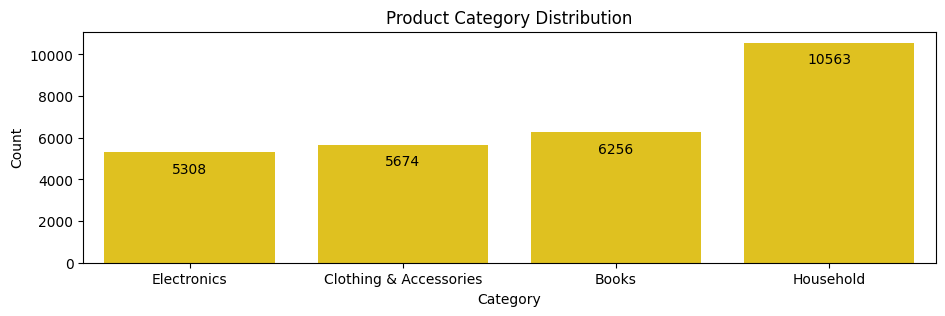

In [17]:
# Plot label counts
plt.figure(figsize = (11, 3))
ax = sns.barplot(x = label_dist.index, y = label_dist.values, color = "gold")

# Add counts on top of bars with formatted numbers
for i, count in enumerate(label_dist.values):
    ax.text(i, count -1000, f"{count}", ha = "center", fontsize = 10)

# Add labels and title
plt.title("Product Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.savefig(FIGURES_DIR / "product-category-distribution.png")

### Label Enconding

Text labels are converted to integer values to make them compatible with the model. This mapping ensures the model can process the target categories effectively.

In [18]:
# Convert textual category labels into integers
label_mapping = {
    "Electronics": 0,
    "Household": 1,
    "Books": 2,
    "Clothing & Accessories": 3
}

data["label"] = data["label"].map(label_mapping)

In [19]:
data.head()

,label,product_description
0,1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,1,SAF 'UV Textured Modern Art Print Framed' Pain...
2,1,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,1,Incredible Gifts India Wooden Happy Birthday U...
4,1,Pitaara Box Romantic Venice Canvas Painting 6m...


### Text Cleaning

Product descriptions are normalized by converting all text to lowercase, removing punctuation, and standardizing whitespace. These steps help reduce noise and improve consistency for better model training.

In [20]:
# Function to normalize and clean the product description text
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()                         # Lowercase everything
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special chars
        text = re.sub(r"\s+", " ", text)            # Replace multiple spaces with one
        return text.strip()
    return ""

# Apply text cleaning
data["product_description"] = data["product_description"].apply(clean_text)

In [21]:
data.head()

,label,product_description
0,1,saf floral framed painting wood 30 inch x 10 i...
1,1,saf uv textured modern art print framed painti...
2,1,saf flower print framed painting synthetic 135...
3,1,incredible gifts india wooden happy birthday u...
4,1,pitaara box romantic venice canvas painting 6m...


### Shuffle the Data

The dataset is shuffled to introduce randomness, helping prevent any order-related bias before training begins.

In [22]:
data = shuffle(data, random_state = 42).reset_index(drop = True)

In [23]:
# Save the cleaned dataset
data.to_csv(PROCESSED_DIR / "ecomm_data_cleaned.csv")

## Data Split

The dataset is divided into training and testing sets to evaluate the model’s performance on unseen data. This split helps ensure the model generalizes well beyond the data it was trained on.

In [24]:
# Split data with stratification to keep label distribution balanced
train_df, test_df = train_test_split(
    data,
    test_size = 0.1,
    stratify = data["label"],
    random_state = 42
)

In [25]:
# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop = True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop = True))

## Tokenization

Product descriptions are converted into tokens using a pretrained DistilBert tokenizer. Each text is truncated or padded to a fixed length so the model receives consistent input sizes. The tokenized data is then formatted as PyTorch tensors, keeping only the input IDs, attention masks, and labels needed for training.

In [26]:
# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenization function with truncation and padding
def tokenize_function(examples):
    return tokenizer(examples["product_description"], truncation = True, padding = "max_length", max_length = 128)

# Apply tokenization
train_tokens = train_dataset.map(tokenize_function, batched = True)
test_tokens = test_dataset.map(tokenize_function, batched = True)

# Set format for PyTorch tensors and keep only necessary columns
columns_to_return = ["input_ids", "attention_mask", "label"]
train_tokens.set_format(type = "torch", columns = columns_to_return)
test_tokens.set_format(type = "torch", columns = columns_to_return)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/25020 [00:00<?, ? examples/s]

Map:   0%|          | 0/2781 [00:00<?, ? examples/s]

## Data Collator

This data collator pads input sequences dynamically to match the longest one in each batch. This makes training more efficient compared to padding all inputs to a fixed maximum length.

In [27]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

## Evaluation Metrics

Several metrics are used to evaluate the model’s performance. Accuracy measures the overall proportion of correct predictions, while precision, recall, and F1 score give insight into how well the model handles each class, especially when the data is imbalanced.

In [28]:
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")


def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis = 1)
    acc = accuracy_metric.compute(predictions = predictions, references = labels)
    prec = precision_metric.compute(predictions = predictions, references = labels, average = "weighted")
    rec = recall_metric.compute(predictions = predictions, references = labels, average = "weighted")
    f1 = f1_metric.compute(predictions = predictions, references = labels, average = "weighted")
    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1["f1"]
    }

## Label Mapping

A reverse mapping from integer IDs back to text labels is created alongside the mapping from labels to IDs. This allows easy conversion between human-readable labels and model-friendly numbers during training and evaluation.

In [29]:
id2label = {v: k for k, v in label_mapping.items()}
label2id = label_mapping

## Load DistilBERT Model

A pretrained DistilBERT model is loaded and adapted for sequence classification tasks. This provides a strong starting point for fine-tuning on the specific dataset.

In [30]:
# Load pretrained model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels = len(label2id),
    id2label = id2label,
    label2id = label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Model Training

The model is fine-tuned on the training data to learn how to classify the product descriptions accurately.

In [31]:
# Enable info-level logging
transformers.logging.set_verbosity_info()

# Check for GPU availability and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Training on device: {device}")

Training on device: cuda


In [32]:
output_dir = (MODELS_DIR / "distilBERT")

In [33]:
training_args = TrainingArguments(
    output_dir = output_dir,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    logging_strategy = "steps",
    logging_steps = 20,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 5,            # Reduced epochs for faster training
    weight_decay = 0.01,
    save_total_limit = 2,            # Keep only last 2 checkpoints to save disk space
    load_best_model_at_end = True,   # Load best model according to eval loss
    metric_for_best_model = "f1",    # Use F1 score to pick best model
    seed = 42,
    report_to = []
)

PyTorch: setting up devices
average_tokens_across_devices is True but world size is 1. Setting it to False automatically.


In [34]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_tokens,
    eval_dataset = test_tokens,
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
)

# Train the model
trainer.train()

/tmp/ipython-input-3492715168.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The following columns in the Training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: product_description. If product_description are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 25,020
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 7,820
  Number of trainable parameters = 66,956,548


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.182900,0.175690,0.957210,0.957280,0.957210,0.957220
2,0.058500,0.176099,0.962603,0.962789,0.962603,0.962637
3,0.110400,0.176126,0.963682,0.963634,0.963682,0.963647
4,0.111900,0.183651,0.965120,0.965225,0.965120,0.965156
5,0.039000,0.206606,0.964042,0.964185,0.964042,0.964060


The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: product_description. If product_description are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2781
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/checkpoint-1564
Configuration saved in /content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/checkpoint-1564/config.json
Model weights saved in /content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/checkpoint-1564/model.safetensors
tokenizer config file saved in /content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/checkpoint-1564/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Colab_Projects/Produ

TrainOutput(global_step=7820, training_loss=0.09761834100586698, metrics={'train_runtime': 1454.1142, 'train_samples_per_second': 86.032, 'train_steps_per_second': 5.378, 'total_flos': 4143065659084800.0, 'train_loss': 0.09761834100586698, 'epoch': 5.0})

## Model Evaluation

The trained model is evaluated on the test set using the metrics set before to measure its performance and ensure it generalizes well.

In [35]:
evaluation_path = (METRICS_RESULTS_DIR / "distilBERT-model-evaluation-metrics.txt")

with open(evaluation_path, "w", encoding = "utf-8") as f:

    def save_metrics(text = ""):
        print(text)
        f.write(text + "
")

    # Evaluate model
    eval_results = trainer.evaluate()

    # Print and save results
    save_metrics("DistilBERT Model Evaluation Metrics on Test Set:
")
    for metric, value in eval_results.items():
        try:
            save_metrics(f"{metric.capitalize()}: {value:.4f}")
        except TypeError:
            save_metrics(f"{metric.capitalize()}: {value}")


The following columns in the Evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: product_description. If product_description are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 2781
  Batch size = 16


DistilBERT Model Evaluation Metrics on Test Set:

Eval_loss: 0.1837
Eval_accuracy: 0.9651
Eval_precision: 0.9652
Eval_recall: 0.9651
Eval_f1: 0.9652
Eval_runtime: 10.3872
Eval_samples_per_second: 267.7350
Eval_steps_per_second: 16.7510
Epoch: 5.0000


In [36]:
# Predict on test set
preds_output = trainer.predict(test_tokens)

# Extract predictions and labels
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: product_description. If product_description are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 2781
  Batch size = 16


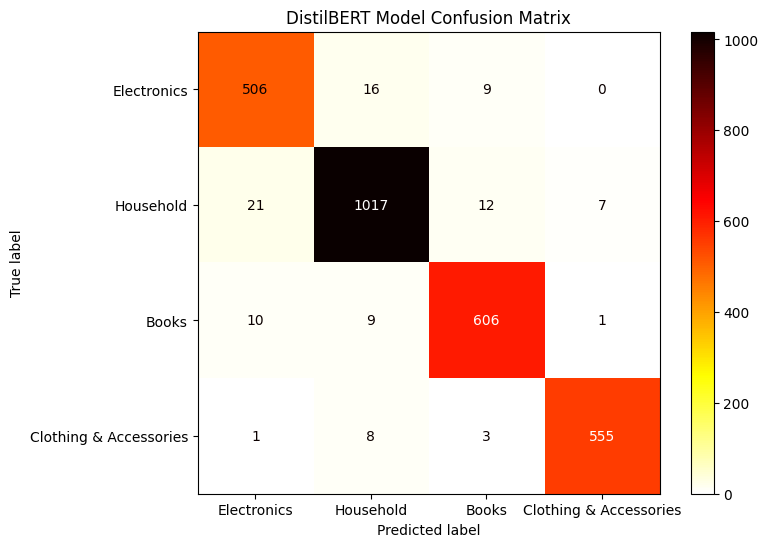

In [37]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize = (8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = id2label.values())
disp.plot(cmap = "hot_r", ax = ax)
plt.title("DistilBERT Model Confusion Matrix")
plt.savefig(FIGURES_DIR / "distilBERT-model-confusion-matrix.png", bbox_inches = "tight")

In [38]:
# Show precision, recall, f1-score per class
class_path = (METRICS_RESULTS_DIR/ "distilBERT-classification-report.txt")

report = classification_report(y_true, y_pred, target_names = id2label.values())

# Print and save
with open(class_path, "w", encoding = "utf-8") as f:
    print("DistilBERT Model Classification Report:
")
    print(report)

    f.write("DistilBERT Model Classification Report:

")
    f.write(report)

DistilBERT Model Classification Report:

                        precision    recall  f1-score   support

           Electronics       0.94      0.95      0.95       531
             Household       0.97      0.96      0.97      1057
                 Books       0.96      0.97      0.96       626
Clothing & Accessories       0.99      0.98      0.98       567

              accuracy                           0.97      2781
             macro avg       0.96      0.97      0.96      2781
          weighted avg       0.97      0.97      0.97      2781



In [39]:
model.save_pretrained(MODELS_DIR / "distilBERT" /"distilBERT-final-model", safe_serialization = False)
tokenizer.save_pretrained(MODELS_DIR / "distilBERT" / "distilBERT-final-model")

Configuration saved in /content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/distilBERT-final-model/config.json
Model weights saved in /content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/distilBERT-final-model/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/distilBERT-final-model/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/distilBERT-final-model/special_tokens_map.json


('/content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/distilBERT-final-model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/distilBERT-final-model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/distilBERT-final-model/vocab.txt',
 '/content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/distilBERT-final-model/added_tokens.json')

## Model Inference

The trained model is used to make predictions on new product descriptions. This step applies the model to real data to get classification results.

In [40]:
# Load the trained model and the tokenizer
model = AutoModelForSequenceClassification.from_pretrained(MODELS_DIR / "distilBERT" / "distilBERT-final-model")
tokenizer = DistilBertTokenizer.from_pretrained(MODELS_DIR / "distilBERT" / "distilBERT-final-model")

loading configuration file /content/drive/MyDrive/Colab_Projects/Product-category-classifier/models/distilBERT/distilBERT-final-model/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Electronics",
    "1": "Household",
    "2": "Books",
    "3": "Clothing & Accessories"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Books": 2,
    "Clothing & Accessories": 3,
    "Electronics": 0,
    "Household": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.55.2",
  "vocab_size": 30522
}

loading weights file /co

In [41]:
# Create a classification pipeline
device_num = 0 if torch.cuda.is_available() else -1
pipeline = TextClassificationPipeline(model = model, tokenizer = tokenizer, device = device_num)

Device set to use cuda:0


In [42]:
# Example input for inference
input_texts = [
    # Electronics
    "Samsung Galaxy Tab S9 Ultra with 14.6'' AMOLED Display and S Pen",
    "Bose QuietComfort Ultra Earbuds – Noise Cancelling, Bluetooth",
    "ASUS ROG Zephyrus Gaming Laptop – Ryzen 9, RTX 4070, 1TB SSD",

    # Household
    "iRobot Roomba i7+ Robot Vacuum with Automatic Dirt Disposal",
    "Keurig K-Elite Single Serve Coffee Maker – Iced Coffee Option",
    "Dyson Pure Cool Link Air Purifier and Fan – WiFi Enabled, HEPA Filter",

    # Books
    "Atomic Habits by James Clear – Build Good Habits & Break Bad Ones",
    "The Hobbit by J.R.R. Tolkien – Illustrated Collector’s Edition",
    "Introduction to Machine Learning with Python by Andreas C. Müller",

    # Clothing
    "Levi’s Men's 511 Slim Fit Jeans – Stretch Denim, Dark Indigo",
    "Nike Women's Dri-FIT Training T-Shirt – Lightweight & Breathable",
    "The North Face Men's Thermoball Eco Jacket – Insulated, Packable",

    # Accessories
    "Ray-Ban RB2132 New Wayfarer Sunglasses – Polarized, Classic Black",
    "Fossil Women's Leather Wallet with RFID Blocking – Zipper Closure",
    "Casio G-Shock Men's Sport Watch – Shock Resistant, Waterproof"
]

In [43]:
predictions_path = (PREDICTIONS_DIR / "predictions_output.txt")

with open(predictions_path, "w", encoding = "utf-8") as f:

    def save_predictions(text = ""):
        print(text)
        f.write(text + "
")

    save_predictions("-" * 40)

    for text in input_texts:
        save_predictions(f"Input Text: {text}
")
        predictions = pipeline(text, return_all_scores = True)[0]
        # Sort predictions by score descending
        predictions = sorted(predictions, key = lambda x: x["score"], reverse = True)
        # Extract top prediction
        top_pred = predictions[0]
        save_predictions(f"Top Prediction: {top_pred['label']} (Confidence: {top_pred['score']:.4f})
")
        # All predictions
        save_predictions("All Predictions:
")
        for pred in predictions:
            save_predictions(f"  {pred['label']}: {pred['score']:.4f}")
        save_predictions("-" * 40)

/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


----------------------------------------
Input Text: Samsung Galaxy Tab S9 Ultra with 14.6'' AMOLED Display and S Pen

Top Prediction: Electronics (Confidence: 0.9980)

All Predictions:

  Electronics: 0.9980
  Books: 0.0011
  Household: 0.0008
  Clothing & Accessories: 0.0001
----------------------------------------
Input Text: Bose QuietComfort Ultra Earbuds – Noise Cancelling, Bluetooth

Top Prediction: Electronics (Confidence: 0.9965)

All Predictions:

  Electronics: 0.9965
  Household: 0.0018
  Books: 0.0017
  Clothing & Accessories: 0.0001
----------------------------------------
Input Text: ASUS ROG Zephyrus Gaming Laptop – Ryzen 9, RTX 4070, 1TB SSD

Top Prediction: Electronics (Confidence: 0.9973)

All Predictions:

  Electronics: 0.9973
  Books: 0.0016
  Household: 0.0011
  Clothing & Accessories: 0.0001
----------------------------------------
Input Text: iRobot Roomba i7+ Robot Vacuum with Automatic Dirt Disposal

Top Prediction: Household (Confidence: 0.9989)

All Predict